# Machine Learning for Emotional Intelligence
## A Combined Multilayer Perceptron/Text Classifier for Predicting Emotion
I wanted to create a proof-of-concept for a mental health tool with an intuitive design. It takes two things from you - a photo and a caption - and predicts what emotion you're experiencing. I designed it as a tool to promote emotional intelligence and, if it were integrated into a mental health app or website's services, suggest resources based on your emotional state.

It works by using a multilayer perceptron (MLP) to predict an emotion from the image, and a text classifier to predict an emotion from the caption. Then, a soft voting ensemble combines those predictions and creates a new, final prediction, with around 52% final accuracy. Plans to improve this model in the future include creating ways to weigh emotions the models are poor at predicting, and findiing higher quality data for training the models.

Please look below for my code.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
#Displays images
from skimage.io import imread
import matplotlib.pyplot as plt
#Backbone of data organization
import numpy as np
import pandas as pd
#Preprocesses text data 
import re
import string
#Needed to unzip image data
import zipfile
#Machine learning tools
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
    utils,
)
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer
#Helps keep track of training times
import time
#Counts instances within a list
from collections import Counter
#For basic visualizations
import seaborn as sns

## The Multilayer Perceptron

The image data was sourced from this Kaggle dataset: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

We start by creating a list with the names of all the images in the 'beta_img' folder. Then, the list is alphabetically sorted. All of the images have corresponding prefixes in their titles denoting which emotion they are meant to represent(ex. a_t for anger, d_t for disgust) so doing this arranges the image titles in the following order - anger, disgust, fear, happiness, neutrality, sadness, surpris.

We utilize 547 images for each emotion, as there were only 547 images that repressented disgust, and I thought it best to have an equal amount of images for each emotion. In total, there were 3,875 images used for this model.

In [3]:
allimg = filter(lambda x: ".jpg" in x, os.listdir("beta_img"))
allimg = list(allimg)
allimg.sort()
allimg[0]

'a_t0.jpg'

After constructing a list with all the names of the images, we create a function which references the actual images within 'beta_img'. Now we have a list with all of the images we need for training/testing.

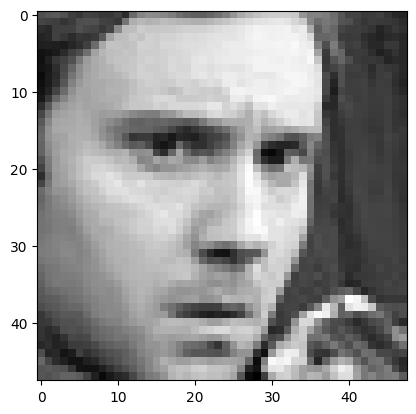

In [4]:
#An example of an image with an angry expression.
allimg = [imread("./beta_img/" + x) for x in list(allimg)]
plt.imshow(allimg[0], cmap = "gray")
plt.show()

We then convert our list of images into a numpy array with one extra axis, which will be needed for input into our multilayer perceptron.

In [5]:
allimg = np.array(allimg)
allimg = allimg[:,:,:,np.newaxis]
allimg.shape

(3829, 48, 48, 1)

Knowing how many of each kind of image is within our model and how they are ordered, creating a dependent variable for our model is as easy as creating a list and adding values that would correspond to each of the emotions in the same order that our list of images was created, and then turning the result into a numpy array.

In [6]:
#Creates emotional correspondence for the images, for the 3829 images we have to train the model with.
#As this is the order that the images were originally loaded in, the data matches up.
#0 will correspond to anger, 1 to disgust, 2 to fear, and so on.
expr = []
for i in range (0,7):
    expr.append([i]*547)
expr = sum(expr, [])
#Converts the expression data to numpy array.
expr = np.array(expr)

Splitting the data, we use a 4:1 ratio for testing and training, respectively. It is important to note the 'random_state' value of 1, because when the data for the text classifier data is similarly split, it must be with the same random_state value to ensure it is split in the exact same way. This is because the soft voting ensemble at the end needs image and text data that correspond to the same emotions; if it uses mismatched data, it will not work.

In [7]:
#Splitting the data into training/testing sets.
img_train, img_test, expr_train, expr_test = tts(allimg, expr, stratify = expr, test_size = 0.2, random_state = 1, shuffle = True)

By taking our image data and resizing it in this way, we make it so that each of the values within the matrices that make up each of the images is between 1 and 0. This normalization benefits the multilayer perceptron by making it faster, more stable, etc.

In [8]:
#Resizes the images for preprocessing.
my_resizer = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
img_train = my_resizer(img_train.astype("float32"))
img_test = my_resizer(img_test.astype("float32"))

We also take our dependent variable array and change it into a format that can be used by our multilayer perceptron's output layer.

In [9]:
#Puts the expressions into an output form suitable to the model.
expr_train = utils.to_categorical(expr_train, 7)
expr_test = utils.to_categorical(expr_test, 7)

In [10]:
expr_train[0:5]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.]])

The model follows a four-step process:
1. Convolute the image data to identify important patterns in images.
2. MaxPool the data to identify prominent features in the images.
3. Drop 20% of the convolution filters to prevent overfitting.
4. Normalize output to keep the model stable.

This process repeats four times, with varying convolutions. At the end, the data is flattened and put into the output layer, which produces the probabilities for each image that they correspond to each of the seven emotions we are testing for.

In [11]:
def model():
    input_layer = layers.Input(img_train.shape[1:])
    #Basic structure - Convolute, MaxPool, Dropout, Normalize.
    #Convolutes image data.
    x = layers.Conv2D(16, 3, dilation_rate = 2, strides=1, activation=LeakyReLU(negative_slope = 0.1), padding="same", kernel_regularizer=l2(0.01))(input_layer)
    #Halves output by taking maximum values of 2x2 areas. Highlights prominient features.
    x = layers.MaxPooling2D()(x)
    #Drops 20% of convolution filters. Prevents overfitting, accelerates calculations.
    x = layers.Dropout(0.2)(x)
    #Standardizes output, stabilizes what goes into the next layer.
    x = layers.BatchNormalization()(x)
    #Repeats 4 times, with more convolutions each time.
    x = layers.Conv2D(32, 3, dilation_rate = 2, strides=1, activation=LeakyReLU(negative_slope = 0.1), padding="same", kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, dilation_rate = 2, strides=1, activation=LeakyReLU(negative_slope = 0.1), padding="same", kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, dilation_rate = 2, strides=1, activation=LeakyReLU(negative_slope = 0.1), padding="same", kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.BatchNormalization()(x)
    #Flattens to produce a 1-dimensional vector from the prior data. Needed for output layer.
    x = layers.Flatten()(x)
    #Dense layer produces probabilities equal to the number of classes.
    output_layer = layers.Dense(7, activation="softmax")(x)
    model = models.Model(input_layer, output_layer)
    return model
model = model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         4,039 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,159 (145.15 KB)

 Trainable params: 36,871 (144.03 KB)

 Non-trainable params: 288 (1.12 KB)

I tweak several of the settings for my model to try to achieve maximum accuracy. In particular, I use Keras' categorical_focal_crossentropy loss function and Adam optimizer, as well as a callback function to stop the model once it reaches the peak of its validation accuracy.

In [12]:
#The Adam optimizer dynamically adjusts learning rate and accelerates convergence.
opt = optimizers.Adam(learning_rate=0.001, beta_1 = 0.9)
my_metrics = ["accuracy", metrics.F1Score()]
#Focuses on difficult-to-classify data.
my_loss = losses.CategoricalFocalCrossentropy(
    #Parameters involved with balancing class weights. 
    alpha=0.25,
    gamma=3.0,
    #Output is raw probability for classes.
    from_logits=False,
    #Prevents "over-confidence" - useful for nuanced ensembles.
    label_smoothing=0.0,
    #Output dimension for which loss is calculated.
    axis=-1,
    #Loss averaged over batch size.
    reduction='sum_over_batch_size',
    #Prioritizes difficult-to-classify examples.
    name='categorical_focal_crossentropy'
)

In [13]:
class CustCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (int(epoch) % 10) == 0:
            accuracy = logs.get('accuracy')
            val_accuracy = logs.get('val_accuracy')
            loss = logs.get('loss')
            print(f"Epoch {epoch}: Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Loss: {loss:.4f}")
        else:
            pass

In [14]:
callbk = [
    CustCallback(),
    # Reduces learning rate when model stops improving validation accuracy.
    callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        # Rate at which learning rate decreases.
        factor=0.1,
        # Waits until ten epochs without improvement to activate.
        patience=10,
        verbose=0,
        mode='auto',
        # Does not wait after reducing learning rate to reduce again.
        cooldown=0,
        # Model cannot surpass this minimum learning rate.
        min_lr=0.000001,
    ),
    # Stops the model training early if validation accuracy does not improve after ten eochs.
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=0,
        patience=10,
        verbose=1,
        mode='auto',
        baseline=None,
        # Restores model to most accurate version if early stopping occurs.
        restore_best_weights=True,
        start_from_epoch=0
     )
]

In [15]:
model.compile(
    loss=my_loss, optimizer=opt, metrics=my_metrics
)

In [16]:
start = time.time()
model.fit(img_train, expr_train, batch_size=32, epochs=1000, shuffle=True, validation_split=0.2, callbacks = callbk, verbose = 0)
end = time.time()
print(end-start)

Epoch 0: Accuracy: 0.1804, Validation Accuracy: 0.1387, Loss: 1.3386
Epoch 10: Accuracy: 0.4380, Validation Accuracy: 0.2724, Loss: 0.3351
Epoch 20: Accuracy: 0.5498, Validation Accuracy: 0.3197, Loss: 0.2628
Epoch 30: Accuracy: 0.6318, Validation Accuracy: 0.3589, Loss: 0.2337
Epoch 40: Accuracy: 0.6298, Validation Accuracy: 0.3736, Loss: 0.2357
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 34.
412.7949481010437


The model's output is a set of seven probabilities within an array. The highest amount within the matrix is the model's prediction (the most likely emotion). Accuracy is determined by the number of correct predictions divided by the number of all predictions. For ease of comprehension, this prediction is matched with an emotional label in the CLASSES list.

In [17]:
#I use an example of a trained model I saved beforehand to facilitate the display of this model's capabilities. 
model = load_model('models/mlp_09082024.h5', custom_objects={'LeakyReLU': LeakyReLU})
results = model.evaluate(img_test, expr_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3611 - f1_score: 0.3578 - loss: 0.3574


In [18]:
CLASSES = np.array(
    [
        "anger",
        "disgust",
        "fear",
        "happiness",
        "neutral",
        "sadness",
        "surprise"
    ]
)

preds = model.predict(img_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(expr_test, axis=-1)]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [19]:
# A raw prediction, a final prediction, and what the prediction was meant to be.
print(preds[0], "\n", preds_single[0], "\n", actual_single[0])

[0.09208257 0.05955623 0.28744435 0.2511964  0.08311796 0.12929142
 0.09731093] 
 fear 
 sadness


Below is the number of correct predictions the model made per emotion. Because we used a 4:1 train-test ratio stratified by emotion, and we're using 3,829 images, there should be around 110 examples of each emotion in the testing data. Therefore, you could interpret the amounts of correct predictions as fractions of 110. These counts are also displayed in a simple histogram for ease of comprehension.

Typically, this model performs best when predicting disgust and surprise. Disgust and surprise, having very distinct facial expressions, are easy for the model to separate from other emotions. With disgust, one's entrie expression tightens, as the nose wrinkles, eyes narrow, and lips withdraw. With surprise it is the opposite, as ones eyes and mouth widen to convey shock. Noticeable features such as these are highlighted well by the model.

The model performs worst, however, when predicting anger and neutrality. Anger, fear, and surprise are correlated emotions, each being a part of the human "fight or flight" reponse. In response to a threat - like, for example, being approached by a wild bear - a physiological reaction coloquially known as the "adrenaline rush" occurs. Surprise may be seen as the initial stage of the fight or flight response, whereas anger and fear correspond to the two options of fighting the threatening stimulus or running away from it. It is therefore possible that the model is confusing anger for fear or surprise at times.

The model's weakness when predicting neutrality is the inverse of its strength in predicting disgust and surprise, because there are very few reliable indicators to distinguish a neutral expression from any other kind. All of the other emotions have distinguishable characteristics, but a neutral expression is somewhere in between those recognizable features. Additionally, as it was not included in Ekman's theory, neutrality is more defined by what it is not than what it is. 

In [20]:
correctpreds = []
for i in range(0, len(preds)):
    if preds_single[i] == actual_single[i]:
        correctpreds.append(preds_single[i])
    else:
        pass
value_counts = dict(Counter(correctpreds))
desired_order = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
value_counts = {x: value_counts[x] for x in desired_order}
print(value_counts)

{'anger': 12, 'disgust': 69, 'fear': 35, 'happiness': 54, 'neutral': 27, 'sadness': 38, 'surprise': 48}


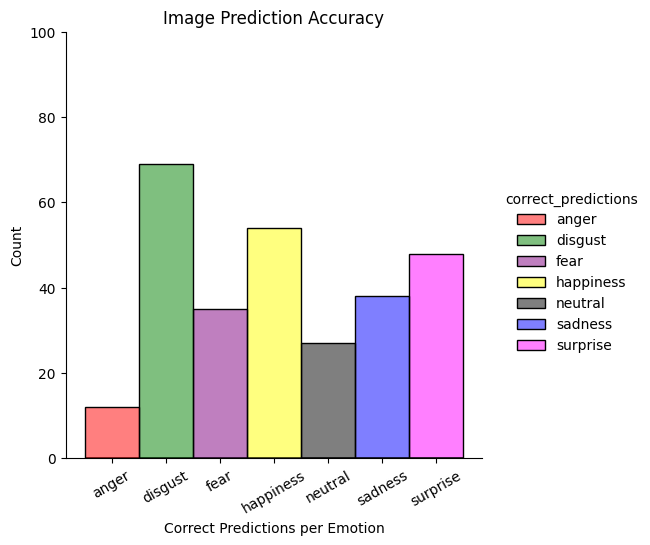

In [21]:
custom_palette = {
    "anger":"red",
    "disgust":"green",
    "fear":"purple",
    "happiness":"yellow",
    "neutral":"black", 
    "sadness":"blue",
    "surprise":"magenta"}
value_countsdf = pd.DataFrame({'correct_predictions':correctpreds})
value_countsdf.sort_values(['correct_predictions'], inplace=True)
plot = sns.displot(data = value_countsdf,
                x = 'correct_predictions',
                kind = 'hist',
                hue = 'correct_predictions',
                palette = custom_palette)
plt.xlabel('Correct Predictions per Emotion')
plt.xticks(rotation=30)
plt.title('Image Prediction Accuracy')
plt.ylim(0, 100)
plt.show()

## The Text Classifier
The text data was sourced from this Kaggle dataset: https://github.com/Valendrew/ekman-emotion-detection

The text data consists of various short comments found on Reddit from various communities. In order to create a soft voting ensemble at the end of this notebook, we must use an equal amount of data as was used for the multilayer perceptron.

In [22]:
test_prompts = pd.read_csv("test_ekmann.csv")
test_prompts.shape

(5427, 3)

In [23]:
train_prompts = pd.read_csv("train_ekmann.csv")
train_prompts.shape

(43410, 3)

In [24]:
# Adding both the training and testing data together.
prompts = pd.concat([test_prompts, train_prompts])
prompts = prompts.sort_values(by='Emotion')
# The first 547 examples of text data for each emotion are taken, becoming the new dataset.
prompts = prompts.groupby('Emotion').head(547)
prompts.shape

(3829, 3)

In [25]:
prompts.tail()


,Text,Emotion,Id
1526,shockingly close to reality.,surprise,edenhhr
12613,This reminds me of suits. (Currently about to ...,surprise,edi17ol
12945,That is so sad. So your sisters got to ruin th...,surprise,eey3lhi
11116,They mean staged. This video is portrayed as a...,surprise,eemvsju
16331,Really? I thought this joke was a bit plane,surprise,eeivot7


Preprocessing the text data for use in a text classifier is a simple process. First, a function is written that will place spaces in between all punctuation marks in a given sentence, and shorten instances where there are multiple spaces in a row to just one space. We then run all entries in our text data through this function and vectorize it.

Vectorization converts our text into matrix data that the model can use. The TF-IDF vectorizer makes it so that words that are frequent across the corpus (the full collection of comments) have low weight, meaning they do not influence the model as much. This screens out commonly used words such as "the", "a", and "and", which are not emotionally charged. On the other hand, rare words that are frequently used in a few comments but not generally among the entire corpus are given extra weight, hopefully allowing the model to "notice" emotionally charged syntax including swears, insults, slang, etc.

In [26]:
def pad_punctuation(s):
    # Places spaces between all punctuation marks.
    s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)
    # Shortens instances with multiple spaces to just one.
    s = re.sub(" +", " ", s)
    return s

text = [pad_punctuation(x) for x in prompts.Text]
emot = [x for x in prompts.Emotion]

In [27]:
# Term Frequency-Inverse Document Frequency - a method of vectorization that converts the text into readable arrays.
# TF (How frequently a word appears) - IDF (Reduces weight of high-frequency words).
vectorizer = TfidfVectorizer()
text = vectorizer.fit_transform(text)

This time, the emotional correspondence to our independent variable comes in the same dataset. We need to first convert the string data into numerical values, so that we can do the exact same preprocessing step we used in the multilayer perceptron. That our models both have similar outputs allows them to be combined at the end.

In [28]:
emot_to_num = {'anger': 0, 'disgust': 1, 'fear': 2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}
emot = [emot_to_num.get(x, x) for x in emot]

In [29]:
set(emot)

{0, 1, 2, 3, 4, 5, 6}

In [30]:
text_train, text_test, emot_train, emot_test = tts(text, emot, stratify = emot, test_size = 0.2, random_state = 1, shuffle = True)

In [31]:
emot_train = utils.to_categorical(emot_train, 7)
emot_test = utils.to_categorical(emot_test, 7)

The Text Classifier uses a simpler three-step process as opposed to the Multilayer Perceptron. The three steps are:
1. Dense layers process the input data and adjust their weights.
2. Dropout layers discard 20% of the neurons to prevent overfitting.
3. Batch Normalization normalizes the output.
After four itierations of this process, the final output is flattened and used in the same kind of output layer as the Multilayer Perceptron.

In [32]:
def model2():
    input_layer = layers.Input(text_train.shape[1:])
    # Simplified three-step process - Dense, Dropout, Normalize
    x = layers.Dense(16, activation=LeakyReLU(negative_slope = 0.1), kernel_regularizer=l2(0.01))(input_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation=LeakyReLU(negative_slope = 0.1), kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation=LeakyReLU(negative_slope = 0.1), kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation=LeakyReLU(negative_slope = 0.1), kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    output_layer = layers.Dense(7, activation="softmax")(x)
    model = models.Model(input_layer, output_layer)
    return model

model2 = model2()
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6951)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │       111,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,975 (453.03 KB)

 Trainable params: 115,687 (451.90 KB)

 Non-trainable params: 288 (1.12 KB)

In [33]:
opt2 = optimizers.Adam(learning_rate=0.001, beta_1 = 0.9)

In [34]:
class CustCallback2(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (int(epoch) % 10) == 0:
            accuracy = logs.get('accuracy')
            loss = logs.get('loss')
            print(f"Epoch {epoch}: Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
        else:
            pass

In [35]:
model2.compile(optimizer = opt2, loss=my_loss, metrics=my_metrics)

In [36]:
start = time.time()
model2.fit(text_train, emot_train, batch_size=32, epochs=100, shuffle=True, callbacks=[CustCallback2()], verbose = 0)
end = time.time()
print(end-start)

Epoch 0: Accuracy: 0.1280, Loss: 1.3807
Epoch 10: Accuracy: 0.6324, Loss: 0.2317
Epoch 20: Accuracy: 0.7189, Loss: 0.1821
Epoch 30: Accuracy: 0.7440, Loss: 0.1785
Epoch 40: Accuracy: 0.7630, Loss: 0.1807
Epoch 50: Accuracy: 0.7545, Loss: 0.1782
Epoch 60: Accuracy: 0.7718, Loss: 0.1832
Epoch 70: Accuracy: 0.7551, Loss: 0.1795
Epoch 80: Accuracy: 0.7653, Loss: 0.1808
Epoch 90: Accuracy: 0.7532, Loss: 0.1818
85.00296974182129


Typically, the Text Classifier does better than the Multilayer Perceptron in terms of predictive power (roughly 3 to 5 percent more accuracy). Relative to the last model, it has much more nuanced predictions - doing better at where the MLP was weak but worse where it was strong.

Comparing the images and text as means of communicating emotion, images are innately better at conveying emotions like surprise than text, especially since we are using short comments with little to no context. Similar differences between the two mediums may explain the variation between the models' performances in certain areas.

In [37]:
model2 = load_model('models/tc_09082024.h5', custom_objects={'LeakyReLU': LeakyReLU})
results2 = model2.evaluate(text_test, emot_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4120 - f1_score: 0.4091 - loss: 0.3866  


In [38]:
preds2 = model2.predict(text_test)
preds_single2 = CLASSES[np.argmax(preds2, axis=-1)]
actual_single2 = CLASSES[np.argmax(emot_test, axis=-1)]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [39]:
print(preds2[0], "\n", preds_single2[0], "\n", actual_single2[0])

[0.01154146 0.00724249 0.00377703 0.40536168 0.0164574  0.14513744
 0.41048247] 
 surprise 
 sadness


In [40]:
correctpreds2 = []
for i in range(0, len(preds2)):
    if preds_single2[i] == actual_single2[i]:
        correctpreds2.append(preds_single2[i])
    else:
        pass
value_counts2 = dict(Counter(correctpreds2))
value_counts2 = {x: value_counts2[x] for x in desired_order}
print(value_counts2)

{'anger': 33, 'disgust': 51, 'fear': 66, 'happiness': 58, 'neutral': 22, 'sadness': 46, 'surprise': 34}


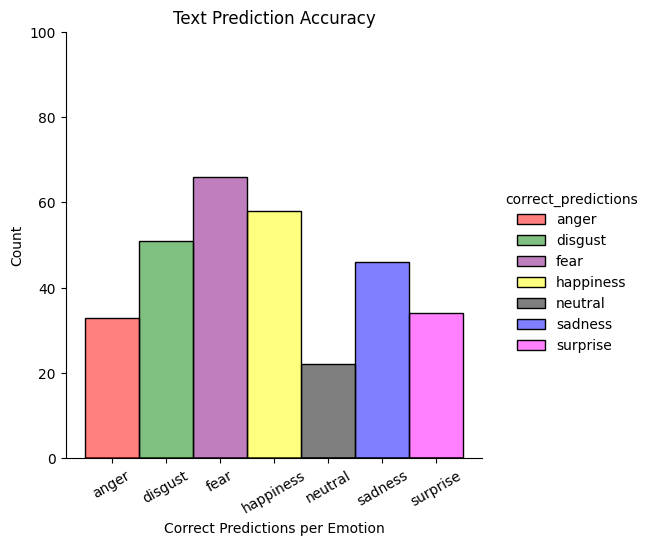

In [41]:
value_counts2df = pd.DataFrame({'correct_predictions':correctpreds2})
value_counts2df.sort_values(['correct_predictions'], inplace=True)
plot2 = sns.displot(data = value_counts2df,
                x = 'correct_predictions',
                kind = 'hist',
                hue = 'correct_predictions',
                palette = custom_palette
                )
plt.xlabel('Correct Predictions per Emotion')
plt.xticks(rotation=30)
plt.title('Text Prediction Accuracy')
plt.ylim(0, 100)
plt.show()

## The Soft Voting Ensemble

Now that we have two established models for predicting emotion, we have to combine their outputs in a soft voting ensemble.

The soft voting ensemble does something very simple - it takes the raw output from the MLP and the raw output from the text classifier for a given image/text combination, weighs each by their respective models' accuracies, and then adds them together. The largest value within the resulting matrix is the combined final prediction.

In [42]:
# I take the output of the perceptron and the classifier, weigh them by their accuracies, and add them.
# The resulting matrix's highest valued class is selected as the final prediction.
def voting_ensemble_soft(imgpred, textpred):
    avg = ((imgpred * results[1]) + (textpred * results2[1]))
    final_prediction = CLASSES[np.argmax(avg)]
    return final_prediction

Using the soft voting ensemble for all image-comment pairs, we can create combined final predictions for all of the data. The accuracy of our voting ensemble, or the number of correct combined predictions divided by the total number of predictions is around 48 - 52% on average, a sizable eight to fifteen percent increase from either individual model.

Though the models' combined strengths make up for their weaknesses, the fact remains that the image and text data used by both come from unrelated sources. If both the image and text data came from the same source, they would have be united in expressing a single emotion, which would reflect in the training. I believe that if this were the case, the model would likely perform much better. 

In [43]:
# Each prediction from the model is put into the voting ensemble. If the resulting combined prediction
# matches the actual emotion for that instance, it is treated as correct. The accuracy of the ensemble is
# the number of correct predictions divided by the number of all predictions.
compreds = []
correctcompreds = []
for i in range (0, len(preds)):
    if voting_ensemble_soft(preds[i], preds2[i]) == actual_single[i]:
        compreds.append(voting_ensemble_soft(preds[i], preds2[i]))
        correctcompreds.append(voting_ensemble_soft(preds[i], preds2[i]))
    else:
        compreds.append(voting_ensemble_soft(preds[i], preds2[i]))
evaluate_voting_accuracy = len(correctcompreds)/len(compreds)
evaluate_voting_accuracy

0.5117493472584856

In [44]:
# A brief comparison of the different models' predictions compared the actual emotion.
val = pd.DataFrame({'imgpreds':preds_single, 'txtpreds':preds_single2, 'compreds':compreds, 'actual':actual_single})
val.head(10)

,imgpreds,txtpreds,compreds,actual
0,fear,surprise,happiness,sadness
1,happiness,happiness,happiness,happiness
2,surprise,neutral,neutral,disgust
3,happiness,happiness,happiness,surprise
4,fear,fear,fear,fear
5,sadness,fear,happiness,fear
6,neutral,happiness,happiness,happiness
7,sadness,anger,anger,happiness
8,disgust,happiness,happiness,neutral
9,neutral,sadness,neutral,neutral


In [45]:
com_value_counts = dict(Counter(correctcompreds))
com_value_counts = {x: com_value_counts[x] for x in desired_order}
print(com_value_counts)

{'anger': 33, 'disgust': 74, 'fear': 66, 'happiness': 73, 'neutral': 32, 'sadness': 50, 'surprise': 64}


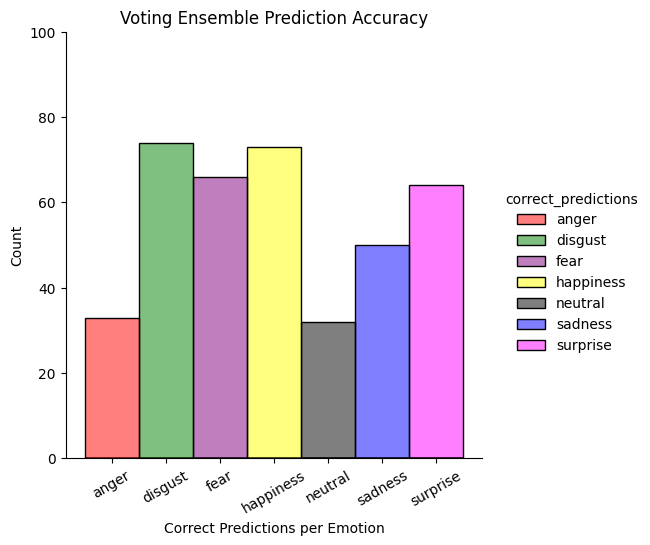

In [46]:
com_value_counts2df = pd.DataFrame({'correct_predictions':correctcompreds})
com_value_counts2df.sort_values(['correct_predictions'], inplace=True)
plot3 = sns.displot(data = com_value_counts2df,
                x = 'correct_predictions',
                kind = 'hist',
                hue = 'correct_predictions',
                palette = custom_palette
                )
plt.xlabel('Correct Predictions per Emotion')
plt.xticks(rotation=30)
plt.title('Voting Ensemble Prediction Accuracy')
plt.ylim(0, 100)
plt.show()